# 1. Importing Libraries


In [317]:
import pandas as pd
from sklearn.model_selection import train_test_split
import catboost as CatBoost
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import numpy as np
import seaborn as sns
from sklearn.impute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier

# 2. Loading and Exploring the Data

In [215]:
df = pd.read_csv('data/cirrhosis.csv')

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df['Status'].value_counts()

# 3. Data Cleaning and Preparation

In [219]:
df.drop(columns='ID', inplace=True)

In [225]:
df['Age'] = round(df['Age']/365.0,2)

# 4. Scaling or Normalizing Data


## `OrdinalEncoder` | `LabelEncoder`

In [224]:
status_enc = OrdinalEncoder(categories= [['C','D','CL']])
df['Status'] = status_enc.fit_transform(df['Status'].values.reshape(-1,1))

lbl_enc = LabelEncoder()
df['Sex'] = lbl_enc.fit_transform(df['Sex'].values)

drug_enc = OrdinalEncoder(categories= [['Placebo','D-penicillamine']], handle_unknown='use_encoded_value', unknown_value=np.nan)
df['Drug'] = drug_enc.fit_transform(df['Drug'].values.reshape(-1,1))

edema_enc = OrdinalEncoder(categories= [['N','S','Y']], handle_unknown='use_encoded_value', unknown_value=np.nan)
df['Edema'] = edema_enc.fit_transform(df['Edema'].values.reshape(-1,1))

yn_enc = OrdinalEncoder(categories= [['N','Y']], handle_unknown='use_encoded_value', unknown_value=np.nan)
df['Ascites'] = yn_enc.fit_transform(df['Ascites'].values.reshape(-1,1))
df['Hepatomegaly'] = yn_enc.fit_transform(df['Hepatomegaly'].values.reshape(-1,1))
df['Spiders'] = yn_enc.fit_transform(df['Spiders'].values.reshape(-1,1))

## `IterativeImputer`

In [236]:
itr_imp = IterativeImputer()
temp = itr_imp.fit_transform(df)
df = pd.DataFrame(temp, columns=df.columns)

# 5. Model Building and Training


In [239]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='Status'),df['Status'], test_size=0.2)

## Functions

### `Importance Features`

In [283]:
def plot_importance_features(model):
    feature_less_importance = [feature  for feature, importance in dict(zip(model.feature_names_in_, model.feature_importances_)).items() if importance < 0.1]
    others = sum([importance  for feature, importance in dict(zip(model.feature_names_in_, model.feature_importances_)).items() if feature in feature_less_importance])

    feature_importance = pd.DataFrame(model.feature_importances_, index=model.feature_names_in_,columns=['importance']).drop(index=feature_less_importance)
    feature_importance.loc['others']=others

    plt.figure(figsize=(10, 3))
    bars = plt.bar(feature_importance.index, feature_importance.importance.values)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.ylim(0,1)
    plt.xticks(rotation=0)
    plt.show()

### `Confusion Matrix`

In [308]:
def plot_confusion_matrix(model, y_test, predictions):
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=status_enc.categories_[0], yticklabels=status_enc.categories_[0])
    plt.xlabel('Predict Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()

In [276]:
status_enc.categories_[0]

array(['C', 'D', 'CL'], dtype=object)

### `Learning Curve`

In [314]:
def plot_learning_curve(model, y_test):
    train_sizes, train_scores, test_scores = learning_curve(model, x_test, y_test, cv=5, n_jobs=-1, scoring='accuracy')

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, label="Training", color="blue")
    plt.plot(train_sizes, test_mean, label="Validation", color="green")
    plt.xlabel('Training set size')
    plt.ylabel('Precision')
    plt.legend(loc="best")
    plt.title("Learning Curve")
    plt.show()


### `Metrics`

In [339]:
list_metrics = []
def save_metrics(model, y_test, predictions):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions,average='macro')
    f1 = f1_score(y_test, predictions,average='macro')
    recall= recall_score(y_test, predictions,average='macro')
    list_metrics.append([model.__class__.__name__,accuracy,precision,f1,recall])

## `Decision Tree Classificator`

In [340]:
dtc = DecisionTreeClassifier(criterion='gini',max_depth=12)

dtc.fit(x_train, y_train)
predictions_1 = dtc.predict(x_test)
save_metrics(dtc, y_test, predictions_1)

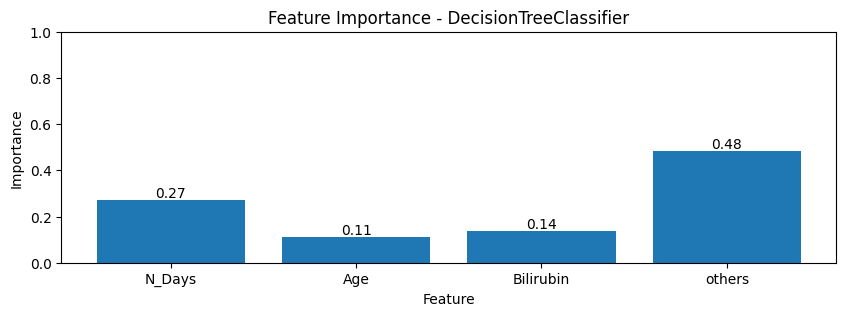

In [300]:
plot_importance_features(dtc)

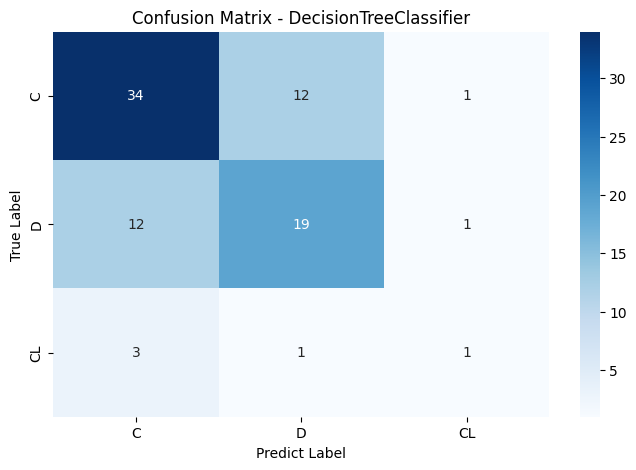

In [309]:
plot_confusion_matrix(dtc,y_test,predictions_1)

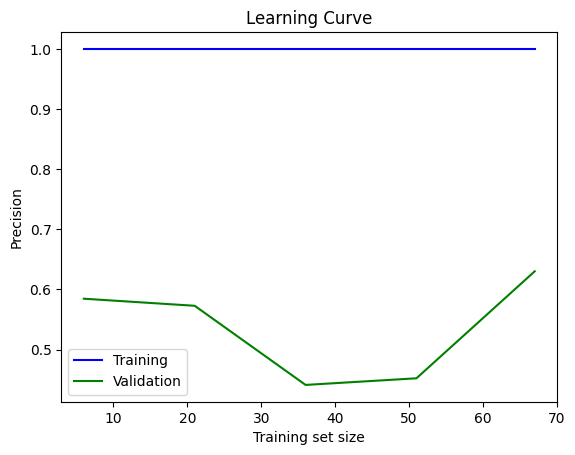

In [316]:
plot_learning_curve(dtc,y_test)

## `Decision Tree Classificator with Bagging`

In [341]:
dtcb = BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',max_depth=16),n_estimators=100)

dtcb.fit(x_train, y_train)
predictions_2 = dtcb.predict(x_test)
save_metrics(dtcb, y_test, predictions_2)

g:\Machine-Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


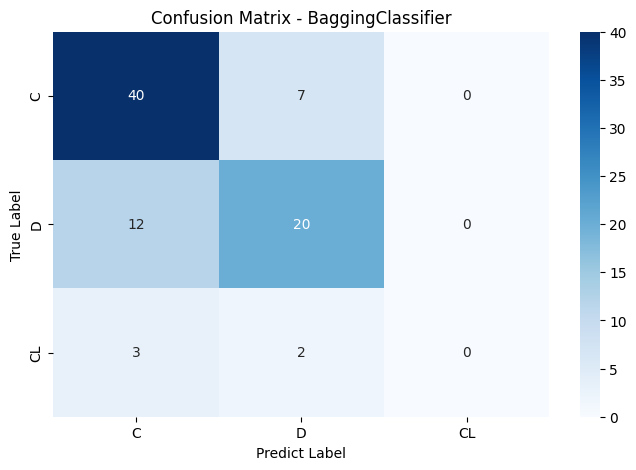

In [337]:
plot_confusion_matrix(dtcb,y_test,predictions_2)

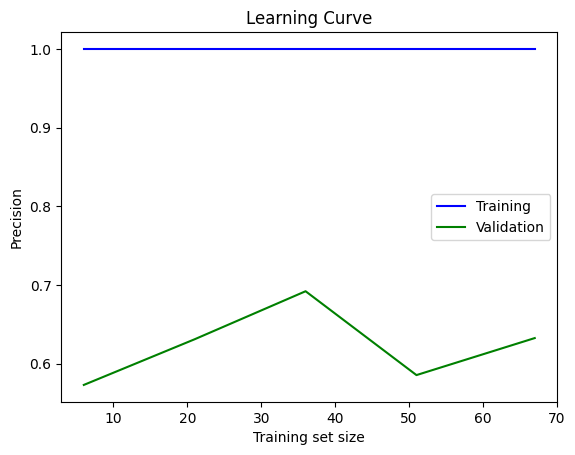

In [371]:
plot_learning_curve(dtcb,y_test)

## `AdaBoost Classifier`

In [369]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='gini',max_depth=16,min_samples_split=20),
                        n_estimators=200,
                        learning_rate=0.1,
                        algorithm='SAMME')

ada.fit(x_train, y_train)
predictions_3 = ada.predict(x_test)
save_metrics(ada, y_test, predictions_3)

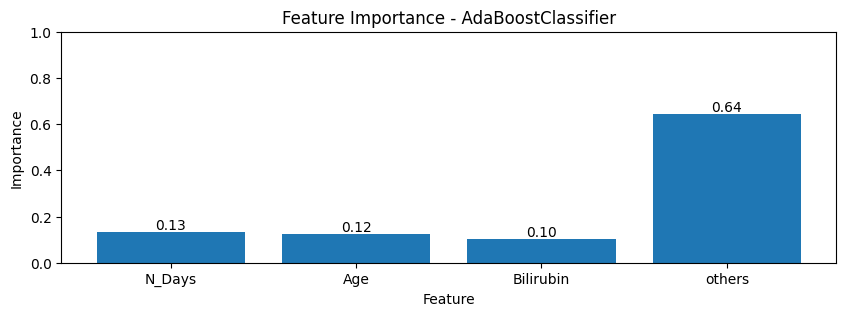

In [373]:
plot_importance_features(ada)

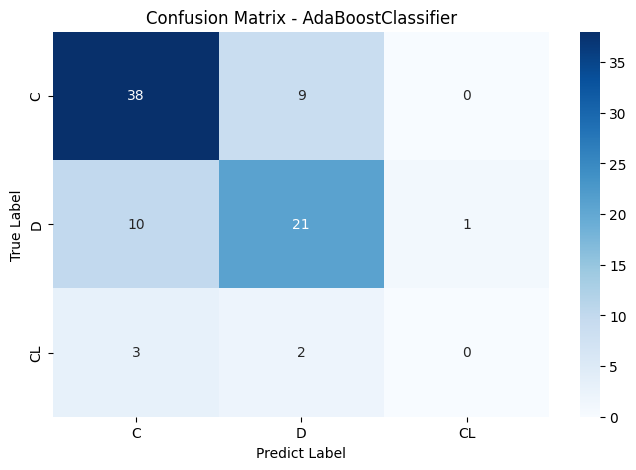

In [370]:
plot_confusion_matrix(ada,y_test,predictions_3)

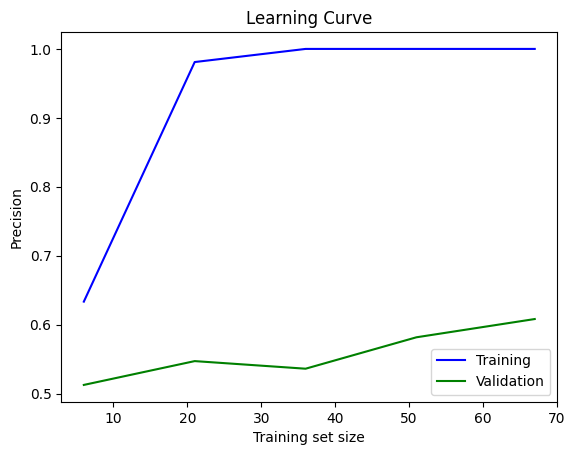

In [374]:
plot_learning_curve(ada,y_test)

## `CatBoost`

In [242]:
cat = CatBoost.CatBoostClassifier(iterations=200, learning_rate=0.1, max_depth=16)

cat.fit(x_train, y_train)

0:	learn: 1.0663672	total: 6.02s	remaining: 19m 58s
1:	learn: 1.0287127	total: 6.83s	remaining: 11m 15s
2:	learn: 0.9988569	total: 9.6s	remaining: 10m 30s
3:	learn: 0.9681077	total: 9.93s	remaining: 8m 6s
4:	learn: 0.9485341	total: 15.5s	remaining: 10m 5s
5:	learn: 0.9230372	total: 21.3s	remaining: 11m 29s
6:	learn: 0.8985072	total: 27.3s	remaining: 12m 32s
7:	learn: 0.8761942	total: 33.4s	remaining: 13m 21s
8:	learn: 0.8587211	total: 39.7s	remaining: 14m 1s
9:	learn: 0.8398919	total: 46s	remaining: 14m 34s
10:	learn: 0.8223109	total: 52.4s	remaining: 15m 1s
11:	learn: 0.8048398	total: 59.5s	remaining: 15m 31s
12:	learn: 0.7865560	total: 1m 6s	remaining: 15m 50s
13:	learn: 0.7693486	total: 1m 12s	remaining: 16m 7s
14:	learn: 0.7500675	total: 1m 15s	remaining: 15m 35s
15:	learn: 0.7348348	total: 1m 21s	remaining: 15m 39s
16:	learn: 0.7211692	total: 1m 27s	remaining: 15m 46s
17:	learn: 0.7068234	total: 1m 34s	remaining: 15m 50s
18:	learn: 0.6930165	total: 1m 39s	remaining: 15m 51s
19:	le

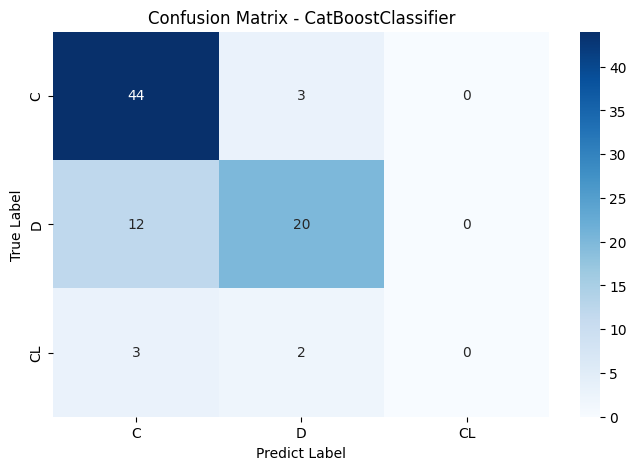

In [342]:
predictions = cat.predict(x_test)

plot_confusion_matrix(cat, y_test, predictions)


array([0., 1., 2.])

# 6. Model Evaluation

In [372]:
pd.DataFrame(list_metrics, columns=['model','accuracy','precision','f1','recall'])

,model,accuracy,precision,f1,recall
0,DecisionTreeClassifier,0.619048,0.491534,0.491534,0.491534
1,BaggingClassifier,0.726190,0.482143,0.487594,0.499113
2,AdaBoostClassifier,0.619048,0.523101,0.500000,0.488209
3,AdaBoostClassifier,0.595238,0.486508,0.480520,0.477349
4,AdaBoostClassifier,0.595238,0.475163,0.475977,0.477349
5,AdaBoostClassifier,0.583333,0.465876,0.466336,0.466933
6,AdaBoostClassifier,0.654762,0.440180,0.440456,0.446587
7,AdaBoostClassifier,0.642857,0.540320,0.517361,0.505718
8,AdaBoostClassifier,0.595238,0.483816,0.476190,0.470700
9,AdaBoostClassifier,0.607143,0.482437,0.481704,0.481117


In [ ]:
df.select_dtypes(object).columns